In [1]:
import pandas as pd
import matplotlib.pyplot as plt

feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+', header=None,names=['column_index','column_name'])
  
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print(feature_name[:10])

['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [7]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [2]:
# 중복된 피처명에 새로운 피처명을 가지도록 dataframe으로 변환하는 함수
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [5]:
def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [11]:
y_train['action'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf=DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
pred=dt_clf.predict(X_test)
accuracy_score(y_test, pred)

0.8581608415337632

In [22]:
dt_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [7]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  3.3min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [6, 8, 10, 12, 16, 20, 24]},
             scoring='accuracy', verbose=1)

In [27]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.8514765743142941
{'max_depth': 8}


In [9]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.849022
1,8,0.852295
2,10,0.846990
3,12,0.842502
4,16,0.845085
5,20,0.838012
6,24,0.841007


In [10]:
max_depths = [6, 8, 10, 12, 16, 20, 24]
for depth in max_depths:
    dt_clf=DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred=dt_clf.predict(X_test)
    accuracy=accuracy_score(y_test, pred)
    print('max_depth={0} 정확도:{1}'.format(depth, accuracy))

max_depth=6 정확도:0.8557855446216491
max_depth=8 정확도:0.8707159823549372
max_depth=10 정확도:0.8673227010519172
max_depth=12 정확도:0.8646080760095012
max_depth=16 정확도:0.8574821852731591
max_depth=20 정확도:0.8547675602307431
max_depth=24 정확도:0.8547675602307431


In [12]:
params ={
    "max_depth" : [8, 12, 16, 20],
    'min_samples_split' : [16, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.7min finished


0.8548794147162603
{'max_depth': 8, 'min_samples_split': 16}


In [14]:
best_dt_clf = grid_cv.best_estimator_
pred=best_dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)

0.8717339667458432


In [16]:
import seaborn as sns
ftr_importances_values = best_dt_clf.feature_importances_
ftr_importances_values

array([0.        , 0.        , 0.        , 0.        , 0.00175182,
       0.        , 0.        , 0.        , 0.        , 0.00217984,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00034009, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00997154, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00122902,
       0.00629033, 0.        , 0.2533544 , 0.002077  , 0.00291231,
       0.        , 0.        , 0.02047009, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0024461 , 0.        , 0.        ,
       0.        , 0.00302454, 0.        , 0.        , 0.10188

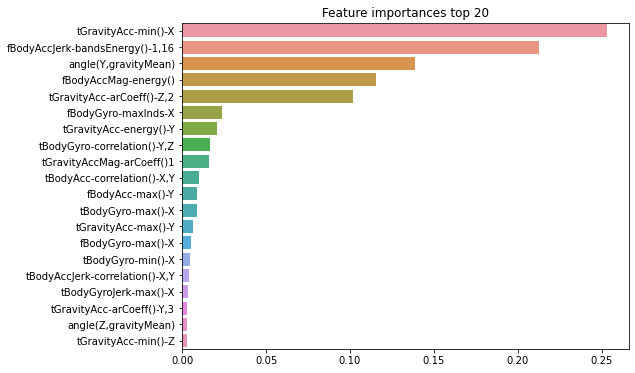

In [20]:
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()